In [11]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
import pylab
from pycbc.filter import matched_filter
import numpy

In [12]:
from pycbc import catalog

### List the mergers in the catalog
for merger_name in catalog.Catalog():
    print(merger_name)

GW170823-v1
GW170818-v1
GW170817-v3
GW170814-v3
GW170809-v1
GW170729-v1
GW170608-v3
GW170104-v2
GW151226-v2
GW151012-v3
GW150914-v3


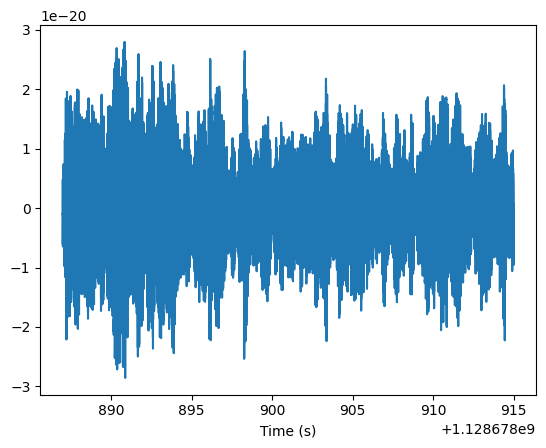

In [13]:
merger = Merger("GW151012")

# Get the data from the Hanford detector
strain = merger.strain("H1")

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0 / 2048)

conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel("Time (s)")
pylab.show()

(30, 1024)

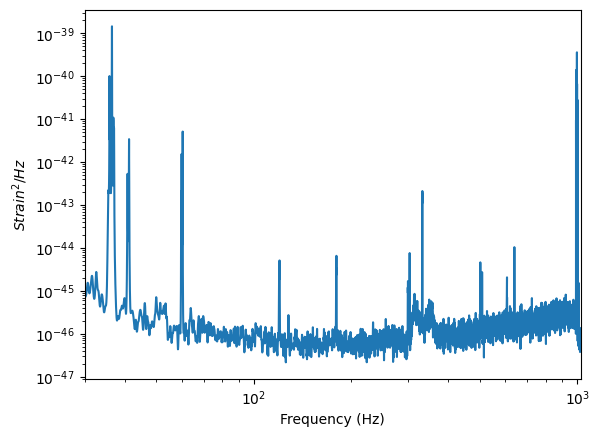

In [14]:
# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency.
psd = inverse_spectrum_truncation(
    psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15
)

pylab.loglog(psd.sample_frequencies, psd)
pylab.ylabel("$Strain^2 / Hz$")
pylab.xlabel("Frequency (Hz)")
pylab.xlim(30, 1024)

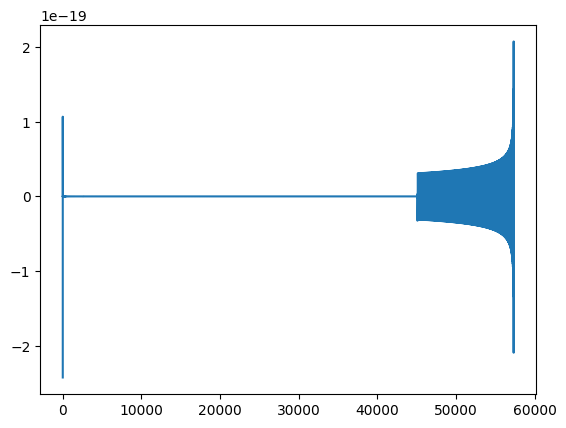

In [19]:
# Solar masses
hp, hc = get_td_waveform(
    approximant="SEOBNRv4_opt",
    mass1=10,
    mass2=10,
    delta_t=conditioned.delta_t,
    f_lower=20,
)

hp.resize(len(conditioned))


template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.show()

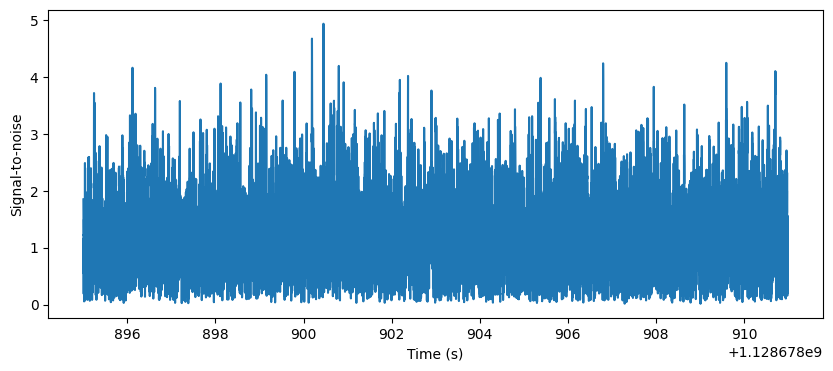

We found a signal at 1128678900.4521484s with SNR 4.932699397404695


In [20]:
snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel("Signal-to-noise")
pylab.xlabel("Time (s)")
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))